---
## **PROJET TAL** : Classification de morceaux de discours mélangés appartenants à 2 anciens présidents de la République française : François Mitterand ou Jacques Chirac
#### **Auteurs** : Mélodie FLEURY, Matéo PETITET 
#### **Matière** : UE TAL par Vincent GUIGUE - 3A IODAA AgroParisTech
#### **Date de rendue** : 12 février 2025
---

### Objectifs
Le but de ce projet est de déterminer à partir d'une liste de phrases si ces dernières ont été prononcées par François Mitterand ou par Jacques Chirac, deux anciens présidents de la République française. Dans ce notebook, différentes méthodes d'apprentissage vont être testées pour évaluer et comparer leur performance de classification.

### Import des librairies nécessaires

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import codecs
import re
import os
import os.path
import string
import time
import logging
import sys
import math
import random
import optuna
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader, TensorDataset, Dataset

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torch.nn as nn
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = "cpu"
print(device)

from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace

#Installation librairie ollama si pas installé
%pip install ollama
import ollama
from ollama import chat
from ollama import ChatResponse

cpu
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Les fonctions utilisées dans ce notebook

In [30]:
def load_pres(fname):
    """
    Chargement des données en séparant les labels (variable "alllabs") des morceaux de discours des 2 anciens présidents (variable "alltxts") dans le fichier

    Args:
        fname (str): chemin du fichier des données d'entraînement et de test

    Returns: 
        alltxts (str): morceaux de discours des 2 anciens président du document
        alllabs (int): label associé à chaque morceau de discours = Si 0 alors la phrase provenait de Mr Mitterand sinon de Mr Chirac
    """
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt).strip()
        if lab.count('M') >0:
            alllabs.append(0)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess(text):
    """
    Applique des pré-traitements sur un fichier textuel ("text"). Par exemple,
    la conversion des mots en minuscule, la suppression des nombres, de la
    ponctuation et des stopwords.

    Args: 
        text (str): Texte brute en entrée

    Returns: 
        text (str) : Texte pré-traité en sortie
    """
    # Conversion en minuscules
    text = text.lower().strip()
    # Suppression des nombres
    text = re.sub('[0-9]+', '', text)
    # Suppression des ponctuations
    punc = string.punctuation  
    punc += '\n\r\t'
    text = text.translate(str.maketrans(punc, ' ' * len(punc)))
    # Suppression des stopwords
    stop_words = set(stopwords.words('french'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Rejoindre les tokens en une chaîne
    text = ' '.join(tokens)
    return text

class TextDataset(Dataset):
    """
    Classe permettant de structurer les morceaux de discours et les labels pour qu'ils soient plus facilement utilisées par un modèle Pytorch
    """
    def __init__(self, texts: list, labels):
        self.labels = labels
        self.phrasesnum = texts

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return self.phrasesnum[i], torch.tensor(self.labels[i])

def collate_fn(batch):
    """
    Personnalise le traitement des données sous forme de batch avant d'être entraîné dans un modèle

    Args:
        batch (tuple): Liste d'échantillon de morceaux de discours ("sequences") et de labels de l'ancien président associés

    Returns:
        padded_sequences (Tensor): Tensor des séquences de longueur uniforme après padding
        torch.tensor(lengths) (Tensor): Tensor contenant les longueurs originales des séquences
        torch.tensor(labels) (Tensor): Tensor contenant les étiquettes du batch
    """
    #Séparation des séquences et des labels sous la forme de tuples
    sequences, labels = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    #permet de mettre toutes les séquences du batch à la même longueur en ajoutant des zéros
    padded_sequences = pad_sequence(sequences, batch_first=False)
    return padded_sequences, torch.tensor(lengths), torch.tensor(labels)

def generate_sinusoidal_embeddings(seq_len, d_model):
    """
    Génération des embeddings positionnels basés sur des sinusoïdes (sine et cosine) pour permettre au modèle de connaître l'ordre des tokens dans une séquence

    Args:
        seq_len (int): Longueur de la séquence
        d_model (int): Dimension de l'espace des embeddings

    Returns:
        : Embedding positionnel sinusoïdal
    """
    #Creation d'un tensor avec des entiers de 0 à seq_len -1
    position = torch.arange(seq_len).unsqueeze(1) #Ajout d'une dimension supplémentaire afin de créer une colonne de positions
    #Génération d'un tensor avec les valeurs appropriées à chaque dimension de d_model
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    #Tensor vide
    pe = torch.zeros(seq_len, d_model)
    #Application de la fonction sinus aux indices impairs des dimensions
    pe[:, 0::2] = torch.sin(position * div_term)
    #Application de la fonction cosinus aux indices pairs des dimensions
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe


def accuracy(yhat,y):
    """
    Calcul de la métrique d'évaluation des modèles avec le dataset de test

    Args:
        yhat (int): label prédit par le modèle
        y (int): label vrai

    Returns:
        Tensor: Accuracy soit la moyenne de bonnes prédictions
    """
    assert len(y.shape)==1 or y.size(1)==1
    return (torch.argmax(yhat,1).view(y.size(0),-1)== y.view(-1,1)).float().mean()

def train(model,epochs,train_loader,test_loader):
    """
    Entraînement du Transformers et récupération des valeurs d'accuracy pour le jeu d'entraînement et de test

    Args:
        model: modèle de Transformers
        epochs (int): nombre d'itération de descente de gradient
        train_loader: Jeu d'entraînement configuré par le DataLoader
        test_loader: Jeu de test configuré par le DataLoader

    Returns:
        list: Listes des valeurs d'accuracy du jeu de donnée d'entraînement et de test
    """
    optim = torch.optim.Adam(model.parameters(),lr=5e-4)    # choix optimizer
    model = model.to(device)
    print(f"running {model.name}")
    loss = nn.CrossEntropyLoss()                            # choix loss
    
    train_accuracies = []
    test_accuracies = []

    for epoch in tqdm(range(epochs)):
        cumloss, cumacc, count = 0, 0, 0
        model.train()
        for x, lengths, y in train_loader:                            # boucle sur les batchs
            optim.zero_grad()
            x,y = x.to(device), y.to(device)                # y doit être un tensor (pas un int)
            yhat = model(x)
            l = loss(yhat,y)
            l.backward()
            optim.step()
            cumloss += l*len(x)                             # attention, il peut y avoir un batch + petit (le dernier)
            cumacc += accuracy(yhat,y)*len(x)
            count += len(x)

        # Calcul de l'accuracy moyenne pour le jeu d'entraînement
        train_accuracy = round((cumacc / count).item(),2)
        train_accuracies.append(train_accuracy)
        
        if epoch % 2 == 0:
            model.eval()
            with torch.no_grad():
                cumloss, cumacc, count = 0, 0, 0
                for x, lengths, y in test_loader:
                    x,y = x.to(device), y.to(device)
                    yhat = model(x)
                    cumloss += loss(yhat,y)*len(x)
                    cumacc += accuracy(yhat,y)*len(x)
                    count += len(x)
                
                # Calcul de l'accuracy moyenne pour le jeu de test
                test_accuracy = round((cumacc / count).item(),2)
                test_accuracies.append(test_accuracy)  # Ajout de l'accuracy test à la liste
                
    print(train_accuracies, test_accuracies)
    return train_accuracies, test_accuracies

#classification zero-shot
def classification_zero_shot(exemple):
    """
    Classification en mode "zero shot" utilisant le modèle Qwen

    Args:
        exemple (str): Phrase à associer au bon ancien président français qui l'a déjà énoncé

    Returns:
        str: Output du modèle Qwen
    """
    prompt = f"You are in a quizz. Here is a quote which has been prononced by an old french president, either Mitterand or Chirac. To win, you have to guess which of them said it sentence using only one word : 'Mitterand' or 'Chirac'. To win you can only say one word. Here is the quote :\n\n{exemple}"
    reponse = ollama.generate(model='qwen2.5:0.5b',prompt=prompt)
    return reponse

#classification few-shot
def classification_few_shot(exemple):
    """
    Classification en mode "few shot" utilisant le modèle Qwen

    Args:
        exemple (str): Phrase à associer au bon ancien président français qui l'a déjà énoncé

    Returns:
        str: Output du modèle Qwen
    """
    #Petit jeu d'entraînement pour le modèle
    txt = ["Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.",
           "A Brazzaville, que l'Afrique de demain se dessine.",
           "Moi je suis du côté de ceux qui pensent qu'il vaut mieux répartir plus justement l'effort et le produit de la nation.",
           "Songez que la femme mariée a eu beaucoup de peine à acquérir un statut juridique conforme à l'idée que nous nous faisons des rapports entre les femmes et les hommes."]
    
    prompt = f"These texts are in the category 'Chirac': \n{txt[0]}\n and \n{txt[1]}.\n\nThese texts are in the category 'Mitterand': \n{txt[2]}\n and \n{txt[-1]}.\n\n Give the category of the following text in only one word: 'Chirac' or 'Mitterand' :\n\n{exemple}"
    reponse = ollama.generate(model='qwen2.5:0.5b',prompt=prompt)
    return reponse

#évaluation des performances de Qwen
def test_perf(dataset,methode,labels_vrais):
    """Évaluation de la bonne classification de chaque phrase à l'ancien président de la République qui l'avait énoncé via l'usage du modèle Qwen

    Args:
        dataset (str): Liste de phrases énoncés soit par Mr François Mitterand soit par Mr Jacques Chirac
        methode (str): choix de la méthode "zero shot" ou "few shot"
        labels_vrais (int): liste des labels rééls à prédire associé aux anciens président français

    Returns:
       int: nombre de phrases bien classées, mal classées ou non classées par le modèle
    """
    # Shuffle two lists with same order
    temp = list(zip(dataset, labels_vrais))
    random.shuffle(temp)
    dataset, labels_vrais = zip(*temp)
    # res1 and res2 come out as tuples, and so must be converted to lists.
    dataset, labels_vrais = list(dataset), list(labels_vrais)

    ok, pb_rep, nul = 0, 0, 0

    pattern_mitterand = re.compile(r"(?i)\s*mitterand\s*[\W]*")
    pattern_chirac = re.compile(r"(?i)\s*chirac\s*[\W]*")
    #(?i) : Active l'option d'insensibilité à la casse (case insensitive), ce qui signifie que "Mitterand" et "mitterand" seront tous deux reconnus.
    #\s* : Correspond à zéro ou plusieurs espaces avant et après le mot "Mitterand".
    #\W : correspond à tout caractère non alphanumérique.

    for k in range(len(dataset)):  # trop d'éléments dans la base de données donc on n'en prend qu'une partie
        response = methode(dataset[k]).response
        if (pattern_mitterand.match(response) and labels_vrais[k] == 0) or (pattern_chirac.match(response) and labels_vrais[k] == 1):
            ok += 1
        elif not pattern_mitterand.match(response) and not pattern_chirac.match(response):
            pb_rep += 1
        else:
            nul += 1

    return ok, pb_rep, nul

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Melo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Melo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Melo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### CHARGEMENT DES JEUX DE DONNÉES

In [31]:
trainCorpus = "./ressources/AFDpresidentutf8/corpus.tache1.learn.utf8"
testCorpus = "./ressources/AFDpresidentutf8/corpus.tache1.test.utf8"

alltxts_train, alllabs_train = load_pres(trainCorpus)
alltxts_test, alllabs_test = load_pres(testCorpus)

In [32]:
#Affichage des données brutes
print(len(alltxts_train),len(alllabs_train))
print(alltxts_train[:3])
print(alllabs_train[:3])
print(alltxts_train[-1])
print(alllabs_train[-1])

57413 57413
["Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.", "D'abord merci de cet exceptionnel accueil que les Congolais, les Brazavillois, nous ont réservé cet après-midi.", "C'est toujours très émouvant de venir en Afrique car c'est probablement l'une des rares terres du monde où l'on ait conservé cette convivialité, cette amitié, ce respect de l'autre qui s'expriment avec chaleur, avec spontanéité et qui réchauffent le coeur de ceux qui arrivent et de ceux qui reçoivent."]
[1, 1, 1]
Je compte sur vous.
1


In [33]:
#permet de compter l'effectif de chaque valeur unique dans une liste
counter_train = Counter(alllabs_train)
counter_test = Counter(alllabs_test)

print("Nombre de phrases du corpus d'entraînement : ", len(alltxts_train))
print("----> # de l'ancien président français Jacques Chirac (label '1') : ", counter_train[1])
print("----> # de l'ancien président français François Mitterand (label '0') : ", counter_train[0])

print("Nombre de phrases du corpus de test : ", len(alllabs_test))
print("----> # de l'ancien président français Jacques Chirac (label '1') : ", counter_test[1])
print("----> # de l'ancien président français François Mitterand (label '0') : ", counter_test[0])

Nombre de phrases du corpus d'entraînement :  57413
----> # de l'ancien président français Jacques Chirac (label '1') :  49890
----> # de l'ancien président français François Mitterand (label '0') :  7523
Nombre de phrases du corpus de test :  27162
----> # de l'ancien président français Jacques Chirac (label '1') :  24244
----> # de l'ancien président français François Mitterand (label '0') :  2918


On peut remarquer que les **classes sont assez déséquilibrées**. En effet, dans le corpus d'entraînement, seulement 13% des phrases ont été prononcées par François Mitterand et 10% pour le corpus de test. Cela peut avoir amener des algorithmes à mieux identifier les phrases de Mr Chirac que ceux de Mr Mitterand.

### PRE-PROCESSING DES DONNÉES BRUTES

In [7]:
#Application du preprocessing à mon texte d'apprentissage et de test
alltxts_train_prep = []
alltxts_test_prep = []

for train_sentence in alltxts_train:
    alltxt_prep = preprocess(train_sentence)
    alltxts_train_prep += [alltxt_prep]

for test_sentence in alltxts_test:
    alltxt_prep = preprocess(test_sentence)
    alltxts_test_prep += [alltxt_prep]

In [8]:
alltxts_train_prep[:10]

['quand dis chers amis agit là formule diplomatique expression ressens',
 'abord merci cet exceptionnel accueil congolais brazavillois réservé cet après midi',
 'toujours très émouvant venir afrique car probablement rares terres monde où conservé cette convivialité cette amitié respect autre expriment chaleur spontanéité réchauffent coeur ceux arrivent ceux reçoivent',
 'aucun citoyen français peut être indifférent séjour brazzaville',
 'congo naguère nom qualifia refuge liberté base départ libération môle résistance comment être heureux retrouver',
 'comment voir signe',
 'brazzaville capitale ordinaire',
 'voies libre disposition peuples coopération explorées a demi siècle ici brazzaville',
 'brazzaville encore quinze années plus tard proclamée communauté',
 'a brazzaville scellée première union régionale pay africains francophones']

### BAG OF WORDS
<span style="color:black"> Les <b> bags of words (BoW) </b> sont une représentation textuelle utilisée pour transformer des textes en vecteurs numériques, où chaque dimension correspond à un mot unique dans un vocabulaire, et la valeur indique le nombre d'occurences de ce mot dans le texte. Cette méthode simple est largement utilisée pour de la classification de texte comme c'est le cas ici. Cependant, cette technique a quelques limites notamment celle <u> de ne pas prendre en compte la position des mots ni les relations sémantiques entre eux </u>. </span>

In [36]:
#Permet de transformer chaque ligne en embedding type "one-hot-encoding"
vectorizer = CountVectorizer()

In [37]:
X_prep = vectorizer.fit_transform(alltxts_train_prep)
X_noprep = vectorizer.fit_transform(alltxts_train)
X_test_prep = vectorizer.fit_transform(alltxts_test_prep)
print(vectorizer.get_feature_names_out()) #tous les mots différents du texte

['abaissant' 'abaissement' 'abaisser' ... 'îlot' 'ôte' 'ôter']


In [10]:
#Naïve Bayes
nb_clf = MultinomialNB()
fit_nb_prep = nb_clf.fit(X_prep, alllabs_train)
fit_nb_noprep = nb_clf.fit(X_noprep, alllabs_train)

#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
fit_lr_prep = lr_clf.fit(X_prep, alllabs_train)
fit_lr_noprep = lr_clf.fit(X_noprep, alllabs_train)

#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5)
fit_svm_prep = svm_clf.fit(X_prep, alllabs_train)
fit_svm_noprep = svm_clf.fit(X_noprep, alllabs_train)

#Labels vrais
true = alllabs_test

#Morceaux de discours avec application des fonctions de préprocessing puis sans
test_corpus_prep = alltxts_test_prep
test_corpus_noprep = alltxts_test

#Application du one-hot-encoding à chaque morceau de discours
X_test_prep = vectorizer.transform(test_corpus_prep)
X_test_noprep = vectorizer.transform(test_corpus_noprep)

#Prédictions des labels
pred_nb_prep = nb_clf.predict(X_test_prep)
pred_nb_noprep = nb_clf.predict(X_test_noprep)

pred_lr_prep = lr_clf.predict(X_test_prep)
pred_lr_noprep = lr_clf.predict(X_test_noprep)

pred_svm_prep = svm_clf.predict(X_test_prep)
pred_svm_noprep = svm_clf.predict(X_test_noprep)

#Calcul de l'accuracy pour chaque modèle avec et sans préprocessing
acc_nb_prep = accuracy_score(true, pred_nb_prep)
acc_nb_noprep = accuracy_score(true, pred_nb_noprep)

acc_lr_prep = accuracy_score(true, pred_lr_prep)
acc_lr_noprep = accuracy_score(true, pred_lr_noprep)

acc_svm_prep = accuracy_score(true, pred_svm_prep)
acc_svm_noprep = accuracy_score(true, pred_svm_noprep)

#Affichage des accuracy pour chaque modèle avec et sans préprocessing
print(f"Naïve Bayes accuracy with preprocessing: {acc_nb_prep}")
print(f"Naïve Bayes accuracy without preprocessing: {acc_nb_noprep}")

print(f"Logistic Regression accuracy with preprocessing: {acc_lr_prep}")
print(f"Logistic Regression accuracy without preprocessing: {acc_lr_noprep}")

print(f"SVM accuracy with preprocessing: {acc_svm_prep}")
print(f"SVM accuracy without preprocessing: {acc_svm_noprep}")

Naïve Bayes accuracy with preprocessing: 0.8094764744864148
Naïve Bayes accuracy without preprocessing: 0.7809439658346219
Logistic Regression accuracy with preprocessing: 0.8557175465724174
Logistic Regression accuracy without preprocessing: 0.8311243649215816
SVM accuracy with preprocessing: 0.8292099256313968
SVM accuracy without preprocessing: 0.7957072380531625


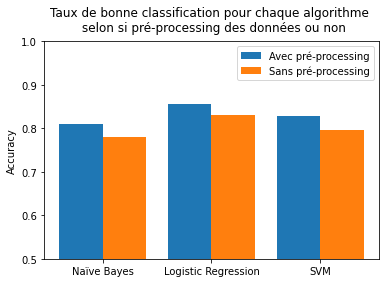

In [ ]:
#Représentation graphique des accuracy avec pré-processing et sans preprocessing
fig, ax = plt.subplots()

X = ['Naïve Bayes', 'Logistic Regression', 'SVM']

prep = [acc_nb_prep, acc_lr_prep, acc_svm_prep]
no_prep = [acc_nb_noprep, acc_lr_noprep, acc_svm_noprep]

X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, prep, 0.4, label = 'Avec pré-processing') 
plt.bar(X_axis + 0.2, no_prep, 0.4, label = 'Sans pré-processing') 

plt.xticks(X_axis, X) 
plt.legend() 
ax.set_ylabel('Accuracy')
ax.set_title("Taux de bonne classification pour chaque algorithme \n selon si pré-processing des données ou non", pad = 10)
ax.set_ylim(0.5,1)

plt.show()

<span style="color:black"> <u> Conclusion : </u> On remarque que le taux de bonne classification des morceaux de discours des 2 anciens présidents de la république est bon. En effet, on obtient des valeurs d'accuracy compris entre entre 0.78 et 0.83. Cependant, on remarque que la régression logistique a de légères meilleures performances que ce soit avec ou sans le pré-processing des données brutes. Concernant, ce pré-processing, on voit que pour les 3 algorithmes utilisés, le pré-processing améliore subtilement les résultats avec une augmentation de 0.015 points en moyenne.</span>

### USAGE D'UN ALGORITHME DE DEEP-LEARNING : TRANSFORMERS
<span style="color:black"> Les <b> Transformers </b> sont des modèles d'apprentissage profond utilisés principalement pour le traitement du langage naturel. Ces types de modèles utilisent un <u> mécanisme d'attention </u> pour traiter simultanément toutes les parties d'une séquence. Cela permet d'analyser efficacement des relations à longue distance dans les données. Ainsi, les Transformers sont particulièrement performants pour des tâches comme de la classification de texte. </span>

In [7]:
# Initialiser un tokenizer WordPiece
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
#taille du vocabulaire
VOC_SIZE = 10000
#taille des batch
BATCH_SIZE = 32
MAX_CHAR_SIZE = 1000
NB_DOC_MAX = 12500 # par classe

# Définir les pré-traitements
tokenizer.pre_tokenizer = Whitespace()

# Créer un entraîneur avec un vocabulaire cible
trainer = WordPieceTrainer(
    vocab_size=10000,  # Limite du vocabulaire
    special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]
)

# Entraîner le tokenizer sur vos données
tokenizer.train_from_iterator(alltxts_train_prep, trainer=trainer)

In [8]:
PAD = tokenizer.encode("[PAD]").ids[0]
print("PAD",PAD)

PAD 3


In [9]:
# fabrication de tous les codes (+ astuce pour ajouter les CLS)
allcodes = [torch.tensor(tokenizer.encode("[CLS] " + p).ids) for p in alltxts_train_prep]
allcodes_test = [torch.tensor(tokenizer.encode("[CLS] " + p).ids) for p in alltxts_test_prep]

In [10]:
ds_train = TextDataset(allcodes,alllabs_train)
ds_test  = TextDataset(allcodes_test,alllabs_test)

In [11]:
train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [12]:
# Test
batch =next(iter( train_loader))
padded_sequences, lengths, labels = batch
print("Padded sequences:", padded_sequences)
print(padded_sequences.size())
# print("Lengths:", lengths)
print("Labels:", labels)

Padded sequences: tensor([[   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1],
        [ 865, 3504, 1029, 6669, 1402, 3524, 1249,  210,  515, 1680, 8817,  684,
          560,  651,  760, 1307,  924, 4811, 1307,  323,    5, 2103, 1031,  609,
          789, 5650, 4390, 1240, 1104, 7074,  273, 8207],
        [4767,  340,  301,  214, 1879, 9817,  550,  599, 1189, 1801, 7420, 7043,
          320, 2351, 2061,  610, 7274,  221, 8854,  321,  232, 2122,  568, 1464,
          221,  108, 1434, 1871, 4465, 1677, 1410,  567],
        [1417, 1182,  482, 2078, 9919,  232,  214, 7656, 1416,  227,  119, 7824,
         1721, 2631,  340, 3763,  420, 3048, 1240, 1299,  486, 2147, 9140,  610,
         2816, 6550, 1598, 2143, 2930,  342,  684,  960],
        [ 143,  418,  209, 1601, 3377, 1797, 1538, 4200, 6632,  725, 1796,  123,
          783,  323, 

In [ ]:
class TransSent(nn.Module):
    """
    Modèle Transformer pour la classification de texte

    Args:
        nn.Module (module): module "Module" de Pytorch
    """

    def __init__(self, emb_size, voc_size, num_layers, num_heads, hidden_size_mlp, output_size, maxlen=1000):
        super(TransSent, self).__init__()

        self.emb_size = emb_size

        # 1. Embedding de chaque mot
        self.emb = nn.Embedding(voc_size, emb_size)
        
        # 2. Transformer Encoder Layer
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_size, 
            nhead=num_heads, 
            dim_feedforward=hidden_size_mlp,
            activation='relu'
        )

        # 3. Transformer Encoder
        self.trans = nn.TransformerEncoder(
            self.encoder_layer, 
            num_layers=num_layers
        )

        # 4. Ajout des embeddings positionnels (sinusoïdaux)
        self.register_buffer("posemb", generate_sinusoidal_embeddings(maxlen, self.emb_size).unsqueeze(1))

        # 5. Couche de classification (depuis le vecteur [CLS])
        self.h2o = nn.Linear(emb_size, output_size)


    def forward(self, input, lengths=None):
        print("input", input.size())
        maxlen = input.size(0)

        padding_mask = (input[:, :] == PAD).T 

        # 1. translation of the input from int to emb + ajout des positional embeddings
        xemb = self.emb(input) 
        xemb += self.posemb[:maxlen,:,:]
        print("xemb", xemb.size())
        
        # 2. Passage dans le transformer... Avec le masque pour le padding
        encoded_output = self.trans(xemb, src_key_padding_mask=padding_mask)
        print("encoded_output", encoded_output.size())
        
        # 3. Appliquer la classification sur le CLS
        output = self.h2o(encoded_output[0,:,:]).squeeze(0)
        
        return output

In [ ]:
# import torch.optim as optim
# # Fonction d'objectif pour Optuna
# def objective(trial):
#     #Suggestion des hyperparamètres
#     emb_size = trial.suggest_int('emb_size', 32, 256, step = 8)
#     num_layers = trial.suggest_int('num_layers', 1, 6)
#     num_heads = trial.suggest_int('num_heads', 2, 8, step = 2)
#     hidden_size_mlp = trial.suggest_int('hidden_size_mlp', 32, 256)
#     num_epochs = trial.suggest_int('num_epochs', 10, 100)
#     batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
#     voc_size = 10000  # Exemple de taille de vocabulaire
#     output_size = 2  # Par exemple, pour une classification binaire

#     # # Vérifiez que emb_size est divisible par num_heads
#     # if emb_size % num_heads != 0:
#     #     raise ValueError("emb_size must be divisible by num_heads")

#     maxlen = 1000

#     # build network
#     model = TransSent(emb_size, voc_size, num_layers, num_heads, hidden_size_mlp , output_size)
    
#     # Définir le critère et l'optimiseur
#     criterion = nn.CrossEntropyLoss()
#     optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
#     lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
#     optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
#     train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
#     val_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
#     #Model training
#     # Entraînement et évaluation
#     for epoch in range(num_epochs):
#         model.train()
#         for x_batch in train_loader:
#             optimizer.zero_grad()
#             outputs = model(x_batch)
#             loss = criterion(outputs, alllabs_train)
#             loss.backward()
#             optimizer.step()

#         # Évaluation sur l'ensemble de test
#         model.eval()
#         with torch.no_grad():
#             test_outputs = model(val_loader)
#             test_loss = criterion(test_outputs, alllabs_test).item()
#             _, predicted = torch.max(test_outputs, 1)
#             accuracy = (predicted == alllabs_test).sum().item() / alllabs_test.size(0)

#         # Report de l'accuracy à Optuna
#         trial.report(accuracy, epoch)

#         # Préparation pour l'early stopping
#         if trial.should_prune():
#             raise optuna.exceptions.TrialPruned()

#     return accuracy
    

In [60]:
# # Lancer l'optimisation avec Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)

# # Afficher les meilleurs hyperparamètres
# print("Best trial:")
# trial = study.best_trial
# print("  Value: {}".format(trial.value))
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

[I 2025-02-11 18:40:11,010] A new study created in memory with name: no-name-30fabd12-4c9a-44c9-98cd-8c480b6b1362
c:\Users\Melo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\Melo\AppData\Local\Temp\ipykernel_16560\942450265.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[W 2025-02-11 18:40:11,051] Trial 0 failed with parameters: {'emb_size': 176, 'num_layers': 1, 'num_heads': 4, 'hidden_size_mlp': 167, 'num_epochs': 20, 'batch_size': 32, 'optimizer': 'Adam', 'lr': 0.0005134366020444682} because of the following error: 

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
# choose hidden size
emb_size = 128
voc_size = 10000
num_layers = 1
num_heads = 1
hidden_size_mlp = 128
output_size = 2
# build network
transf = TransSent( emb_size, voc_size, num_layers, num_heads, hidden_size_mlp , output_size)
transf.name = "TransSent-"+time.asctime()

In [ ]:
# #Usage de la fonction perte de CrossEntropy
# loss = nn.CrossEntropyLoss()
# # batch
# x, lengths, y = next(iter(train_loader))
# print(x.size(),y.size())

# yhat = transf(x)
# print(yhat.size())
# l = loss(yhat,y)

torch.Size([63, 32]) torch.Size([32])
input torch.Size([63, 32])
xemb torch.Size([63, 32, 128])
encoded_output torch.Size([63, 32, 128])
torch.Size([32, 2])


In [30]:
#training du transformers
n_epoch = 15
train_list, test_list = train(transf, n_epoch, train_loader, test_loader)

running TransSent-Sun Feb  9 20:30:18 2025


  0%|          | 0/15 [00:00<?, ?it/s]

input torch.Size([48, 32])
xemb torch.Size([48, 32, 128])
encoded_output torch.Size([48, 32, 128])
input torch.Size([78, 32])
xemb torch.Size([78, 32, 128])
encoded_output torch.Size([78, 32, 128])
input torch.Size([109, 32])
xemb torch.Size([109, 32, 128])
encoded_output torch.Size([109, 32, 128])
input torch.Size([71, 32])
xemb torch.Size([71, 32, 128])
encoded_output torch.Size([71, 32, 128])
input torch.Size([86, 32])
xemb torch.Size([86, 32, 128])
encoded_output torch.Size([86, 32, 128])
input torch.Size([133, 32])
xemb torch.Size([133, 32, 128])
encoded_output torch.Size([133, 32, 128])
input torch.Size([74, 32])
xemb torch.Size([74, 32, 128])
encoded_output torch.Size([74, 32, 128])
input torch.Size([54, 32])
xemb torch.Size([54, 32, 128])
encoded_output torch.Size([54, 32, 128])
input torch.Size([105, 32])
xemb torch.Size([105, 32, 128])
encoded_output torch.Size([105, 32, 128])
input torch.Size([58, 32])
xemb torch.Size([58, 32, 128])
encoded_output torch.Size([58, 32, 128])
i

  7%|▋         | 1/15 [01:48<25:19, 108.55s/it]

input torch.Size([49, 32])
xemb torch.Size([49, 32, 128])
encoded_output torch.Size([49, 32, 128])
input torch.Size([66, 32])
xemb torch.Size([66, 32, 128])
encoded_output torch.Size([66, 32, 128])
input torch.Size([65, 32])
xemb torch.Size([65, 32, 128])
encoded_output torch.Size([65, 32, 128])
input torch.Size([55, 32])
xemb torch.Size([55, 32, 128])
encoded_output torch.Size([55, 32, 128])
input torch.Size([82, 26])
xemb torch.Size([82, 26, 128])
encoded_output torch.Size([82, 26, 128])
input torch.Size([69, 32])
xemb torch.Size([69, 32, 128])
encoded_output torch.Size([69, 32, 128])
input torch.Size([53, 32])
xemb torch.Size([53, 32, 128])
encoded_output torch.Size([53, 32, 128])
input torch.Size([65, 32])
xemb torch.Size([65, 32, 128])
encoded_output torch.Size([65, 32, 128])
input torch.Size([83, 32])
xemb torch.Size([83, 32, 128])
encoded_output torch.Size([83, 32, 128])
input torch.Size([71, 32])
xemb torch.Size([71, 32, 128])
encoded_output torch.Size([71, 32, 128])
input torc

 13%|█▎        | 2/15 [03:27<22:17, 102.86s/it]

input torch.Size([61, 32])
xemb torch.Size([61, 32, 128])
encoded_output torch.Size([61, 32, 128])
input torch.Size([73, 32])
xemb torch.Size([73, 32, 128])
encoded_output torch.Size([73, 32, 128])
input torch.Size([67, 32])
xemb torch.Size([67, 32, 128])
encoded_output torch.Size([67, 32, 128])
input torch.Size([57, 32])
xemb torch.Size([57, 32, 128])
encoded_output torch.Size([57, 32, 128])
input torch.Size([58, 32])
xemb torch.Size([58, 32, 128])
encoded_output torch.Size([58, 32, 128])
input torch.Size([64, 32])
xemb torch.Size([64, 32, 128])
encoded_output torch.Size([64, 32, 128])
input torch.Size([69, 32])
xemb torch.Size([69, 32, 128])
encoded_output torch.Size([69, 32, 128])
input torch.Size([104, 32])
xemb torch.Size([104, 32, 128])
encoded_output torch.Size([104, 32, 128])
input torch.Size([96, 32])
xemb torch.Size([96, 32, 128])
encoded_output torch.Size([96, 32, 128])
input torch.Size([66, 32])
xemb torch.Size([66, 32, 128])
encoded_output torch.Size([66, 32, 128])
input t

 20%|██        | 3/15 [05:19<21:23, 106.92s/it]

input torch.Size([82, 26])
xemb torch.Size([82, 26, 128])
encoded_output torch.Size([82, 26, 128])
input torch.Size([54, 32])
xemb torch.Size([54, 32, 128])
encoded_output torch.Size([54, 32, 128])
input torch.Size([92, 32])
xemb torch.Size([92, 32, 128])
encoded_output torch.Size([92, 32, 128])
input torch.Size([70, 32])
xemb torch.Size([70, 32, 128])
encoded_output torch.Size([70, 32, 128])
input torch.Size([96, 32])
xemb torch.Size([96, 32, 128])
encoded_output torch.Size([96, 32, 128])
input torch.Size([114, 32])
xemb torch.Size([114, 32, 128])
encoded_output torch.Size([114, 32, 128])
input torch.Size([67, 32])
xemb torch.Size([67, 32, 128])
encoded_output torch.Size([67, 32, 128])
input torch.Size([58, 32])
xemb torch.Size([58, 32, 128])
encoded_output torch.Size([58, 32, 128])
input torch.Size([85, 32])
xemb torch.Size([85, 32, 128])
encoded_output torch.Size([85, 32, 128])
input torch.Size([71, 32])
xemb torch.Size([71, 32, 128])
encoded_output torch.Size([71, 32, 128])
input t

 27%|██▋       | 4/15 [06:59<19:08, 104.45s/it]

input torch.Size([48, 5])
xemb torch.Size([48, 5, 128])
encoded_output torch.Size([48, 5, 128])
input torch.Size([82, 32])
xemb torch.Size([82, 32, 128])
encoded_output torch.Size([82, 32, 128])
input torch.Size([69, 32])
xemb torch.Size([69, 32, 128])
encoded_output torch.Size([69, 32, 128])
input torch.Size([43, 32])
xemb torch.Size([43, 32, 128])
encoded_output torch.Size([43, 32, 128])
input torch.Size([66, 32])
xemb torch.Size([66, 32, 128])
encoded_output torch.Size([66, 32, 128])
input torch.Size([73, 32])
xemb torch.Size([73, 32, 128])
encoded_output torch.Size([73, 32, 128])
input torch.Size([97, 32])
xemb torch.Size([97, 32, 128])
encoded_output torch.Size([97, 32, 128])
input torch.Size([61, 32])
xemb torch.Size([61, 32, 128])
encoded_output torch.Size([61, 32, 128])
input torch.Size([77, 32])
xemb torch.Size([77, 32, 128])
encoded_output torch.Size([77, 32, 128])
input torch.Size([62, 32])
xemb torch.Size([62, 32, 128])
encoded_output torch.Size([62, 32, 128])
input torch.S

 33%|███▎      | 5/15 [08:43<17:22, 104.30s/it]

encoded_output torch.Size([55, 32, 128])
input torch.Size([52, 32])
xemb torch.Size([52, 32, 128])
encoded_output torch.Size([52, 32, 128])
input torch.Size([57, 32])
xemb torch.Size([57, 32, 128])
encoded_output torch.Size([57, 32, 128])
input torch.Size([47, 32])
xemb torch.Size([47, 32, 128])
encoded_output torch.Size([47, 32, 128])
input torch.Size([84, 32])
xemb torch.Size([84, 32, 128])
encoded_output torch.Size([84, 32, 128])
input torch.Size([46, 32])
xemb torch.Size([46, 32, 128])
encoded_output torch.Size([46, 32, 128])
input torch.Size([43, 32])
xemb torch.Size([43, 32, 128])
encoded_output torch.Size([43, 32, 128])
input torch.Size([49, 32])
xemb torch.Size([49, 32, 128])
encoded_output torch.Size([49, 32, 128])
input torch.Size([66, 32])
xemb torch.Size([66, 32, 128])
encoded_output torch.Size([66, 32, 128])
input torch.Size([65, 32])
xemb torch.Size([65, 32, 128])
encoded_output torch.Size([65, 32, 128])
input torch.Size([55, 32])
xemb torch.Size([55, 32, 128])
encoded_ou

 40%|████      | 6/15 [10:08<14:37, 97.49s/it] 

input torch.Size([40, 5])
xemb torch.Size([40, 5, 128])
encoded_output torch.Size([40, 5, 128])
input torch.Size([79, 32])
xemb torch.Size([79, 32, 128])
encoded_output torch.Size([79, 32, 128])
input torch.Size([87, 32])
xemb torch.Size([87, 32, 128])
encoded_output torch.Size([87, 32, 128])
input torch.Size([55, 32])
xemb torch.Size([55, 32, 128])
encoded_output torch.Size([55, 32, 128])
input torch.Size([69, 32])
xemb torch.Size([69, 32, 128])
encoded_output torch.Size([69, 32, 128])
input torch.Size([81, 32])
xemb torch.Size([81, 32, 128])
encoded_output torch.Size([81, 32, 128])
input torch.Size([85, 32])
xemb torch.Size([85, 32, 128])
encoded_output torch.Size([85, 32, 128])
input torch.Size([70, 32])
xemb torch.Size([70, 32, 128])
encoded_output torch.Size([70, 32, 128])
input torch.Size([85, 32])
xemb torch.Size([85, 32, 128])
encoded_output torch.Size([85, 32, 128])
input torch.Size([71, 32])
xemb torch.Size([71, 32, 128])
encoded_output torch.Size([71, 32, 128])
input torch.S

 47%|████▋     | 7/15 [11:36<12:35, 94.38s/it]

encoded_output torch.Size([47, 32, 128])
input torch.Size([84, 32])
xemb torch.Size([84, 32, 128])
encoded_output torch.Size([84, 32, 128])
input torch.Size([46, 32])
xemb torch.Size([46, 32, 128])
encoded_output torch.Size([46, 32, 128])
input torch.Size([43, 32])
xemb torch.Size([43, 32, 128])
encoded_output torch.Size([43, 32, 128])
input torch.Size([49, 32])
xemb torch.Size([49, 32, 128])
encoded_output torch.Size([49, 32, 128])
input torch.Size([66, 32])
xemb torch.Size([66, 32, 128])
encoded_output torch.Size([66, 32, 128])
input torch.Size([65, 32])
xemb torch.Size([65, 32, 128])
encoded_output torch.Size([65, 32, 128])
input torch.Size([55, 32])
xemb torch.Size([55, 32, 128])
encoded_output torch.Size([55, 32, 128])
input torch.Size([82, 26])
xemb torch.Size([82, 26, 128])
encoded_output torch.Size([82, 26, 128])
input torch.Size([69, 32])
xemb torch.Size([69, 32, 128])
encoded_output torch.Size([69, 32, 128])
input torch.Size([40, 32])
xemb torch.Size([40, 32, 128])
encoded_ou

 53%|█████▎    | 8/15 [12:55<10:26, 89.56s/it]

input torch.Size([45, 5])
xemb torch.Size([45, 5, 128])
encoded_output torch.Size([45, 5, 128])
input torch.Size([69, 32])
xemb torch.Size([69, 32, 128])
encoded_output torch.Size([69, 32, 128])
input torch.Size([94, 32])
xemb torch.Size([94, 32, 128])
encoded_output torch.Size([94, 32, 128])
input torch.Size([61, 32])
xemb torch.Size([61, 32, 128])
encoded_output torch.Size([61, 32, 128])
input torch.Size([52, 32])
xemb torch.Size([52, 32, 128])
encoded_output torch.Size([52, 32, 128])
input torch.Size([77, 32])
xemb torch.Size([77, 32, 128])
encoded_output torch.Size([77, 32, 128])
input torch.Size([75, 32])
xemb torch.Size([75, 32, 128])
encoded_output torch.Size([75, 32, 128])
input torch.Size([57, 32])
xemb torch.Size([57, 32, 128])
encoded_output torch.Size([57, 32, 128])
input torch.Size([58, 32])
xemb torch.Size([58, 32, 128])
encoded_output torch.Size([58, 32, 128])
input torch.Size([71, 32])
xemb torch.Size([71, 32, 128])
encoded_output torch.Size([71, 32, 128])
input torch.S

 60%|██████    | 9/15 [14:26<09:00, 90.16s/it]

encoded_output torch.Size([65, 32, 128])
input torch.Size([55, 32])
xemb torch.Size([55, 32, 128])
encoded_output torch.Size([55, 32, 128])
input torch.Size([82, 26])
xemb torch.Size([82, 26, 128])
encoded_output torch.Size([82, 26, 128])
input torch.Size([52, 32])
xemb torch.Size([52, 32, 128])
encoded_output torch.Size([52, 32, 128])
input torch.Size([102, 32])
xemb torch.Size([102, 32, 128])
encoded_output torch.Size([102, 32, 128])
input torch.Size([58, 32])
xemb torch.Size([58, 32, 128])
encoded_output torch.Size([58, 32, 128])
input torch.Size([44, 32])
xemb torch.Size([44, 32, 128])
encoded_output torch.Size([44, 32, 128])
input torch.Size([56, 32])
xemb torch.Size([56, 32, 128])
encoded_output torch.Size([56, 32, 128])
input torch.Size([86, 32])
xemb torch.Size([86, 32, 128])
encoded_output torch.Size([86, 32, 128])
input torch.Size([55, 32])
xemb torch.Size([55, 32, 128])
encoded_output torch.Size([55, 32, 128])
input torch.Size([77, 32])
xemb torch.Size([77, 32, 128])
encoded

 67%|██████▋   | 10/15 [15:46<07:15, 87.06s/it]

input torch.Size([60, 32])
xemb torch.Size([60, 32, 128])
encoded_output torch.Size([60, 32, 128])
input torch.Size([55, 32])
xemb torch.Size([55, 32, 128])
encoded_output torch.Size([55, 32, 128])
input torch.Size([72, 32])
xemb torch.Size([72, 32, 128])
encoded_output torch.Size([72, 32, 128])
input torch.Size([78, 32])
xemb torch.Size([78, 32, 128])
encoded_output torch.Size([78, 32, 128])
input torch.Size([33, 5])
xemb torch.Size([33, 5, 128])
encoded_output torch.Size([33, 5, 128])
input torch.Size([105, 32])
xemb torch.Size([105, 32, 128])
encoded_output torch.Size([105, 32, 128])
input torch.Size([75, 32])
xemb torch.Size([75, 32, 128])
encoded_output torch.Size([75, 32, 128])
input torch.Size([79, 32])
xemb torch.Size([79, 32, 128])
encoded_output torch.Size([79, 32, 128])
input torch.Size([52, 32])
xemb torch.Size([52, 32, 128])
encoded_output torch.Size([52, 32, 128])
input torch.Size([94, 32])
xemb torch.Size([94, 32, 128])
encoded_output torch.Size([94, 32, 128])
input torc

 73%|███████▎  | 11/15 [17:17<05:52, 88.10s/it]

encoded_output torch.Size([55, 32, 128])
input torch.Size([52, 32])
xemb torch.Size([52, 32, 128])
encoded_output torch.Size([52, 32, 128])
input torch.Size([57, 32])
xemb torch.Size([57, 32, 128])
encoded_output torch.Size([57, 32, 128])
input torch.Size([47, 32])
xemb torch.Size([47, 32, 128])
encoded_output torch.Size([47, 32, 128])
input torch.Size([84, 32])
xemb torch.Size([84, 32, 128])
encoded_output torch.Size([84, 32, 128])
input torch.Size([46, 32])
xemb torch.Size([46, 32, 128])
encoded_output torch.Size([46, 32, 128])
input torch.Size([43, 32])
xemb torch.Size([43, 32, 128])
encoded_output torch.Size([43, 32, 128])
input torch.Size([49, 32])
xemb torch.Size([49, 32, 128])
encoded_output torch.Size([49, 32, 128])
input torch.Size([66, 32])
xemb torch.Size([66, 32, 128])
encoded_output torch.Size([66, 32, 128])
input torch.Size([65, 32])
xemb torch.Size([65, 32, 128])
encoded_output torch.Size([65, 32, 128])
input torch.Size([55, 32])
xemb torch.Size([55, 32, 128])
encoded_ou

 80%|████████  | 12/15 [18:40<04:19, 86.61s/it]

input torch.Size([66, 32])
xemb torch.Size([66, 32, 128])
encoded_output torch.Size([66, 32, 128])
input torch.Size([60, 32])
xemb torch.Size([60, 32, 128])
encoded_output torch.Size([60, 32, 128])
input torch.Size([68, 32])
xemb torch.Size([68, 32, 128])
encoded_output torch.Size([68, 32, 128])
input torch.Size([69, 32])
xemb torch.Size([69, 32, 128])
encoded_output torch.Size([69, 32, 128])
input torch.Size([38, 5])
xemb torch.Size([38, 5, 128])
encoded_output torch.Size([38, 5, 128])
input torch.Size([83, 32])
xemb torch.Size([83, 32, 128])
encoded_output torch.Size([83, 32, 128])
input torch.Size([52, 32])
xemb torch.Size([52, 32, 128])
encoded_output torch.Size([52, 32, 128])
input torch.Size([61, 32])
xemb torch.Size([61, 32, 128])
encoded_output torch.Size([61, 32, 128])
input torch.Size([63, 32])
xemb torch.Size([63, 32, 128])
encoded_output torch.Size([63, 32, 128])
input torch.Size([69, 32])
xemb torch.Size([69, 32, 128])
encoded_output torch.Size([69, 32, 128])
input torch.S

 87%|████████▋ | 13/15 [20:20<03:01, 90.64s/it]

encoded_output torch.Size([97, 32, 128])
input torch.Size([60, 32])
xemb torch.Size([60, 32, 128])
encoded_output torch.Size([60, 32, 128])
input torch.Size([81, 32])
xemb torch.Size([81, 32, 128])
encoded_output torch.Size([81, 32, 128])
input torch.Size([66, 32])
xemb torch.Size([66, 32, 128])
encoded_output torch.Size([66, 32, 128])
input torch.Size([46, 32])
xemb torch.Size([46, 32, 128])
encoded_output torch.Size([46, 32, 128])
input torch.Size([67, 32])
xemb torch.Size([67, 32, 128])
encoded_output torch.Size([67, 32, 128])
input torch.Size([55, 32])
xemb torch.Size([55, 32, 128])
encoded_output torch.Size([55, 32, 128])
input torch.Size([52, 32])
xemb torch.Size([52, 32, 128])
encoded_output torch.Size([52, 32, 128])
input torch.Size([57, 32])
xemb torch.Size([57, 32, 128])
encoded_output torch.Size([57, 32, 128])
input torch.Size([47, 32])
xemb torch.Size([47, 32, 128])
encoded_output torch.Size([47, 32, 128])
input torch.Size([84, 32])
xemb torch.Size([84, 32, 128])
encoded_ou

 93%|█████████▎| 14/15 [21:44<01:28, 88.62s/it]

input torch.Size([86, 5])
xemb torch.Size([86, 5, 128])
encoded_output torch.Size([86, 5, 128])
input torch.Size([79, 32])
xemb torch.Size([79, 32, 128])
encoded_output torch.Size([79, 32, 128])
input torch.Size([52, 32])
xemb torch.Size([52, 32, 128])
encoded_output torch.Size([52, 32, 128])
input torch.Size([63, 32])
xemb torch.Size([63, 32, 128])
encoded_output torch.Size([63, 32, 128])
input torch.Size([63, 32])
xemb torch.Size([63, 32, 128])
encoded_output torch.Size([63, 32, 128])
input torch.Size([68, 32])
xemb torch.Size([68, 32, 128])
encoded_output torch.Size([68, 32, 128])
input torch.Size([99, 32])
xemb torch.Size([99, 32, 128])
encoded_output torch.Size([99, 32, 128])
input torch.Size([50, 32])
xemb torch.Size([50, 32, 128])
encoded_output torch.Size([50, 32, 128])
input torch.Size([77, 32])
xemb torch.Size([77, 32, 128])
encoded_output torch.Size([77, 32, 128])
input torch.Size([74, 32])
xemb torch.Size([74, 32, 128])
encoded_output torch.Size([74, 32, 128])
input torch.S

100%|██████████| 15/15 [23:21<00:00, 93.41s/it]

encoded_output torch.Size([66, 32, 128])
input torch.Size([46, 32])
xemb torch.Size([46, 32, 128])
encoded_output torch.Size([46, 32, 128])
input torch.Size([67, 32])
xemb torch.Size([67, 32, 128])
encoded_output torch.Size([67, 32, 128])
input torch.Size([55, 32])
xemb torch.Size([55, 32, 128])
encoded_output torch.Size([55, 32, 128])
input torch.Size([52, 32])
xemb torch.Size([52, 32, 128])
encoded_output torch.Size([52, 32, 128])
input torch.Size([57, 32])
xemb torch.Size([57, 32, 128])
encoded_output torch.Size([57, 32, 128])
input torch.Size([47, 32])
xemb torch.Size([47, 32, 128])
encoded_output torch.Size([47, 32, 128])
input torch.Size([84, 32])
xemb torch.Size([84, 32, 128])
encoded_output torch.Size([84, 32, 128])
input torch.Size([46, 32])
xemb torch.Size([46, 32, 128])
encoded_output torch.Size([46, 32, 128])
input torch.Size([43, 32])
xemb torch.Size([43, 32, 128])
encoded_output torch.Size([43, 32, 128])
input torch.Size([49, 32])
xemb torch.Size([49, 32, 128])
encoded_ou

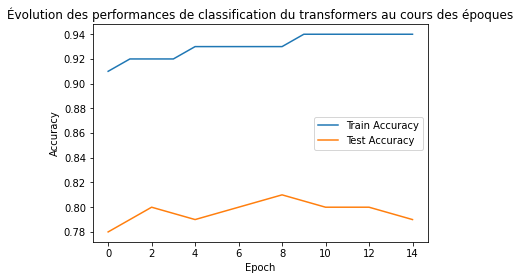

In [31]:
# À la fin de l'entraînement, on trace le graphique de l'accuracy
plt.plot(range(n_epoch), train_list, label='Train Accuracy')
plt.plot(range(0, n_epoch, 2), test_list, label='Test Accuracy')  # Afficher l'accuracy de test tous les 2 epochs
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Évolution des performances de classification du transformers au cours des époques')
plt.legend()
plt.show()

<span style="color:black"> <u> Conclusion : </u> On remarque que le taux de bonne classification des morceaux de discours des 2 anciens présidents de la république en utilisant un transformers est bon aussi. En effet, on a au minimum 79% des discours qui ont été bien classés en appliquant le pré-processing sur les données brutes. Cependant, on remarque un grand écart entre l'accuracy du jeu d'entraînement et du jeu de test. On pourrait donc émettre l'hypothèse d'un surapprentissage du modèle. Pour éviter le surapprentissage, il est possible de faire de la régularisation en appliquant la technique dropout ou en augmentant les poids des observations mal classées.</span>

### Ollama

<span style="color:black"> Ollama est une plateforme permettant de télécharger et exécuter localement des modèles de langage open-source optimisé. Parmi les modèles proposés, il y a Qwen qui est réputé pour être un bon équilibre entre la performance et le poids. Pour évaluer la performance du modèle de langage Qwen sur cette tâche, on va utiliser 2 méthodes différentes appelées "zero shot" et "few shot". Le premier consiste à réaliser de la classification sans exemple et le second, de la classification avec quelques exemples. On va analyser s'il y a des différentes de performances ou pas à l'aide de la fonction "test_perf".</span>

In [10]:
#Lancement de la classification du modèle Qwen en mode "zero shot" et "few shot"
rep_0shot = classification_zero_shot(alltxts_train[115])
print(alllabs_train[115])
print(rep_0shot.response)

rep_fewshot = classification_few_shot(alltxts_train[115])
print(alltxts_train[115])
print(rep_fewshot.response)

0
Mitterand
Oui ! Mais il ne faut pas que pour autant, cela prive l'enfant de la protection à laquelle il a droit et qui dans certains cas doit être renforcée.
Chirac


In [28]:
n = 50

#Taux d'accuracy classification zero shot modèle ollama
o1,p1,n1 = test_perf(alltxts_test_prep[:n], classification_zero_shot, alllabs_test[:n])
print(o1,p1,n1)

perc_o1 = 100*o1/(len(alltxts_test_prep[:n]))
perc_p1 = 100*p1/(len(alltxts_test_prep[:n]))
perc_n1 = 100*n1/(len(alltxts_test_prep[:n]))

print(
    'Zero-shot\n ok : ', perc_o1, '%', 
    'Nuls : ', perc_n1, '%', 
    'Mauvais format de réponse : ', perc_p1, '%.')

#Taux d'accuracy classification few shot modèle ollama
o2,p2,n2 = test_perf(alltxts_test_prep[:n], classification_few_shot, alllabs_test[:n])

perc_o2 = 100*o2/(len(alltxts_test_prep[:n]))
perc_p2 = 100*p2/(len(alltxts_test_prep[:n]))
perc_n2 = 100*n2/(len(alltxts_test_prep[:n]))

print(
    'Few-shot\n ok : ', perc_o2, '%', 
    'nuls : ', perc_n2, '%', 
    'Mauvais format de réponse : ', perc_p2, '%.')

ceci est une bonne réponse : Mitterand
ceci est de mauvais format de réponse :  Musée
ceci est une mauvaise réponse :  Mitterand
ceci est de mauvais format de réponse :  To win, I will think of a single word from either Mitterand or Chirac that fits the context of this sentence. Let me consider each option:

1. **Mitterand**: The quote mentions "alger", which could be a reference to Algeria, and "sceau nom" seems related to names. If we're focusing on naming an individual, Mitterand could fit well with Alger.

2. **Chirac**: The quote also mentions the word "cérémonie", and it's worth considering if Chirac might have a name that fits this context.

Based on the provided information:
- Mitterand is from the former French President.
- Chirac was an important French leader during his time as Prime Minister.

I'll analyze whether either of them could fit the context perfectly. Let me guess: **Mitterand** seems more likely given that Alger and "cérémonie" might be directly related to politi

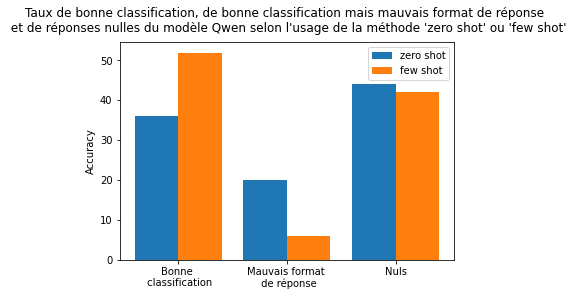

In [12]:
#Représentation graphique des accuracy avec la méthode zero shot et few shot
fig, ax = plt.subplots()

X = ['Bonne \n classification', 'Mauvais format \n de réponse', 'Nuls']

zero_shot = [perc_o1, perc_p1, perc_n1]
few_shot = [perc_o2, perc_p2, perc_n2]

X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, zero_shot, 0.4, label = 'zero shot') 
plt.bar(X_axis + 0.2, few_shot, 0.4, label = 'few shot') 

plt.xticks(X_axis, X) 
plt.legend() 
ax.set_ylabel('Accuracy')
ax.set_title(
    "Taux de bonne classification, de bonne classification mais mauvais format de réponse \n et de réponses nulles du modèle Qwen selon l'usage de la méthode 'zero shot' ou 'few shot'", 
    pad = 10)

plt.show()

<span style="color:black"> <u> Conclusion : </u> On remarque que le taux de bonne classification des morceaux de discours des 2 anciens présidents de la république en utilisant le modèle Qwen d'Ollama est drastiquement plus élevé en donnant quelques exemples au modèle (méthode "few-shot") que sans (méthode "one-shot"). En effet, on passe d'un score de 30% environ à quasiment 70% de phrases associées à son bon auteur. Également, le taux de mauvaise classification diminue en utilisant la méthode "few-shot" en passant de 25% de mauvaise classification avec la méthode "zero-shot" à 4%. Concernant les phrases non-classées par le modèle, on passe de 50% avec la méthode zero-shot (elle est par ailleurs la classe majoritaire avec cette dernière méthode) à moins de 30%. Cependant, cela représente tout de même une grande proportion. Cela représente donc une des limites de ces modèles qui ne se situe ni dans la bonne classification ni dans la mauvaise. Il est alors plus difficile de comprendre comment améliorer le modèle. Cependant, on peut également dans certains cas y déceler peut-être d'autres classes qui n'avaient pas été considéré au départ dans les données brutes. .</span>